In [1]:
#export
"""
Bare example of how this module works::

    import k1lib
    
    class CbA(k1lib.Callback):
        def __init__(self):
            super().__init__()
            self.initialState = 3
        def startBatch(self):
            print("startBatch - CbA")
        def startPass(self):
            print("startPass - CbA")

    class CbB(k1lib.Callback):
        def startBatch(self):
            print("startBatch - CbB")
        def endLoss(self):
            print("endLoss - CbB")

    # initialization
    cbs = k1lib.Callbacks()
    cbs.append(CbA()).append(CbB())
    model = lambda xb: xb + 3
    lossF = lambda y, yb: y - yb
    
    # training loop
    cbs("startBatch"); xb = 6; yb = 2
    cbs("startPass"); y = model(xb); cbs("endPass")
    cbs("startLoss"); loss = lossF(y, yb); cbs("endLoss")
    cbs("endBatch")
    
    print(cbs.CbA) # can reference the Callback object directly

So, point is, you can define lots of :class:`Callback` classes that
defines a number of checkpoint functions, like ``startBatch``. Then,
you can create a :class:`Callbacks` object that includes Callback
objects. When you do ``cbs("checkpoint")``, this will execute
``cb.checkpoint()`` of all the Callback objects.

Pretty much everything here is built upon this. The core training loop
has nothing to do with ML stuff. In fact, it's just a bunch of
``cbs("...")`` statements. Everything meaningful about the training
loop comes from different Callback classes. Advantage of this is that you
can tack on wildly different functions, have them play nicely with each
other, and remove entire complex functionalities by commenting out a
single line."""
import k1lib, time, os, logging, numpy as np, matplotlib.pyplot as plt
from typing import Set, List, Union, Callable, ContextManager, Iterator
from collections import OrderedDict

In [2]:
#export
__all__ = ["Callback", "Callbacks"]

In [3]:
#export
class Callback:
    r"""Represents a callback. Define specific functions
inside to intercept certain parts of the training
loop. Can access :class:`k1lib.Learner` like this::

    self.l.xb = self.l.xb[None]

This takes x batch of learner, unsqueeze it at
the 0 position, then sets the x batch again.

Normally, you will define a subclass of this and
define specific intercept functions, but if you
want to create a throwaway callback, then do this::

    Callback().withCheckpoint("startRun", lambda: print("start running"))

You can use `.cls` for a list of default Callback
classes, for any particular needs.

**order**

You can also use `.order` to set the order of execution of the callback.
The higher, the later it gets executed. Value suggestions:

- 7: pre-default runs, like LossLandscape
- 10: default runs, like DontTrainValid
- 13: custom mods, like ModifyBatch
- 15: pre-recording mod
- 17: recording mods, like Profiler.memory
- 20: default recordings, like Loss
- 23: post-default recordings, like ParamFinder
- 25: guards, like TimeLimit, CancelOnExplosion

Just leave as default (10) if you don't know what values to choose.

**dependsOn**

If you're going to extend this class, you can also specify dependencies
like this::

    class CbC(k1lib.Callback):
        def __init__(self):
            super().__init__()
            self.dependsOn = {"Loss", "Accuracy"}

This is so that if somewhere, ``Loss`` callback class is temporarily
suspended, then CbC will be suspended also, therefore avoiding errors.

**Suspension**

If your Callback is mainly dormant, then you can do something like this::

    class CbD(k1lib.Callback):
        def __init__(self):
            super().__init__()
            self.suspended = True
        def startBatch(self):
            # these types of methods will only execute
            # if ``self.suspended = False``
            pass
        def analyze(self):
            self.suspended = False
            # do something that sometimes call ``startBatch``
            self.suspended = True

    cbs = k1lib.Callbacks().append(CbD())
    # dormant phase:
    cbs("startBatch") # does not execute CbD.startBatch()
    # active phase
    cbs.CbB.analyze() # does execute CbD.startBatch()

So yeah, you can easily make every checkpoint active/dormant by changing
a single variable, how convenient. See over :meth:`Callbacks.suspend`
for more."""
    def __init__(self):
        self.l = None; self.cbs = None; self.suspended = False; self.paused = False
        self.name = self.__class__.__name__; self.dependsOn:Set[str] = set()
        self.order = 10 # can be modified by subclasses. A smaller order will be executed first
    def suspend(self):
        """Checkpoint, called when the Callback is temporarily suspended. Overridable"""
        pass
    def restore(self):
        """Checkpoint, called when the Callback is back from suspension. Overridable"""
        pass
    def __getstate__(self):
        state = dict(self.__dict__)
        del state["l"]; del state["cbs"]; return state
    def __setstate__(self, state): self.__dict__.update(state)
    def __repr__(self): return f"{self._reprHead}, can...\n{self._reprCan}"
    @property
    def _reprHead(self): return f"Callback `{self.name}`"
    @property
    def _reprCan(self): return """- cb.something: to get specific attribute "something" from learner if not available
- cb.withCheckpoint(checkpoint, f): to quickly insert an event handler
- cb.detach(): to remove itself from its parent Callbacks"""
    def withCheckpoint(self, checkpoint:str, f:Callable[["Callback"], None]):
        """Quickly set a checkpoint, for simple, inline-able functions

:param checkpoint: checkpoints like "startRun"
:param f: function that takes in the Callback itself"""
        setattr(self, checkpoint, lambda: f(self)); return self
    def __call__(self, checkpoint):
        if not self.suspended and hasattr(self, checkpoint):
            return getattr(self, checkpoint)() != None
    def detach(self):
        """Detaches from the parent :class:`Callbacks`"""
        self.cbs.remove(self.name); return self
Callback.cls = k1lib.Object()
Callback.lossCls = k1lib.Object()

In [4]:
#export
class PauseContext:
    def __init__(self, cb): self.cb = cb
    def __enter__(self): self.oldValue = self.cb.paused; self.cb.paused = True
    def __exit__(self, *ignored): self.cb.paused = self.oldValue
@k1lib.patch(Callback)
def pause(self):
    """Pauses the callback's main functionality for a while. This is a bit different
from :meth:`Callbacks.suspend`, in that :meth:`Callbacks.suspend` will not call any
cb's checkpoints at all. However, pausing it will only set an internal variable ``paused``,
but all the checkpoints will be called normally. :class:`Callback` objects can then
choose to turn off some checkpoints if deemed appropriate.

This is kinda a niche functionality, and very few built-in :class:`Callback` s actually
use this."""
    return PauseContext(self)

In [5]:
#export
class Timings:
    """List of checkpoint timings. Not intended to be instantiated by the end user.
Used within :class:`~k1lib.callbacks.callbacks.Callbacks`, accessible via
:attr:`Callbacks.timings` to record time taken to execute a single
checkpoint. This is useful for profiling stuff."""
    @property
    def state(self):
        answer = dict(self.__dict__); answer.pop("getdoc", None); return answer
    @property
    def checkpoints(self) -> List[str]:
        """List of all checkpoints encountered"""
        return [cp for cp in self.state if k1lib.isNumeric(self[cp])]
    def __getattr__(self, attr):
        if attr.startswith("_"): raise AttributeError()
        self.__dict__[attr] = 0; return 0
    def __getitem__(self, idx): return getattr(self, idx)
    def __setitem__(self, idx, value): setattr(self, idx, value)
    def plot(self):
        """Plot all checkpoints' execution times"""
        plt.figure(dpi=100); checkpoints = self.checkpoints
        timings = np.array([self[cp] for cp in checkpoints])
        maxTiming = timings.max()
        if maxTiming >= 1:
            plt.bar(checkpoints, timings); plt.ylabel("Time (s)")
        elif maxTiming >= 1e-3 and maxTiming < 1:
            plt.bar(checkpoints, timings*1e3); plt.ylabel("Time (ms)")
        elif maxTiming >= 1e-6 and maxTiming < 1e-3:
            plt.bar(checkpoints, timings*1e6); plt.ylabel("Time (us)")
        plt.xticks(rotation="vertical"); plt.show()
    def clear(self):
        """Clears all timing data"""
        for cp in self.checkpoints: self[cp] = 0
    def __repr__(self):
        cps = '\n'.join([f'- {cp}: {self[cp]}' for cp in self.checkpoints])
        return f"""Timings object. Checkpoints:\n{cps}\n
Can...
- t.startRun: to get specific checkpoint's execution time
- t.plot(): to plot all checkpoints"""

In [6]:
#export
class Callbacks:
    def __init__(self):
        self._l: k1lib.Learner = None; self.cbsDict = {}; self._timings = Timings()
    @property
    def timings(self) -> Timings:
        """Returns :class:`~k1lib.callbacks.callbacks.Timings` object"""
        return self._timings
    @property
    def l(self) -> "k1lib.Learner":
        """:class:`k1lib.Learner` object. Will be set automatically when
you set :attr:`k1lib.Learner.cbs` to this :class:`Callbacks`"""
        return self._l
    @l.setter
    def l(self, learner):
        self._l = learner
        for cb in self.cbs: cb.l = learner
    @property
    def cbs(self) -> List[Callback]: return [*self.cbsDict.values()] # convenience method for looping over stuff
    def _sort(self) -> "Callbacks":
        self.cbsDict = OrderedDict(sorted(self.cbsDict.items())); return self
    def append(self, cb:Callback, name:str=None):
        """Adds a callback to the collection."""
        if cb in self.cbs: cb.l = self.l; cb.cbs = self; return self
        cb.l = self.l; cb.cbs = self; name = name or cb.name
        if name in self.cbsDict:
            i = 0
            while f"{name}{i}" in self.cbsDict: i += 1
            name = f"{name}{i}"
        cb.name = name; self.cbsDict[name] = cb; self._sort()
        self._appendContext_append(cb); cb("appended"); return self
    def __contains__(self, e:str) -> bool: return e in self.cbsDict
    def remove(self, *names:List[str]):
        """Removes a callback from the collection."""
        for name in names:
            if name not in self.cbsDict: return print(f"Callback `{name}` not found")
            cb = self.cbsDict[name]; del self.cbsDict[name]; cb("detached")
        self._sort(); return self
    def removePrefix(self, prefix:str):
        """Removes any callback with the specified prefix"""
        for cb in self.cbs:
            if cb.name.startswith(prefix): self.remove(cb.name)
        return self
    def __call__(self, *checkpoints:List[str]) -> bool:
        """Calls a number of checkpoints one after another.
Returns True if any of the checkpoints return anything at all"""
        self._checkpointGraph_call(checkpoints)
        answer = False
        for checkpoint in checkpoints:
            beginTime = time.time()
            answer |= any([cb(checkpoint) for cb in self.cbs])
            self._timings[checkpoint] += time.time() - beginTime
        return answer
    def __getitem__(self, idx:Union[int, str]) -> Callback:
        return self.cbs[idx] if isinstance(idx, int) else self.cbsDict[idx]
    def __iter__(self) -> Iterator[Callback]:
        for cb in self.cbsDict.values(): yield cb
    def __len__(self): return len(self.cbsDict)
    def __getattr__(self, attr):
        if attr == "cbsDict": raise AttributeError(attr)
        if attr in self.cbsDict: return self.cbsDict[attr]
        else: raise AttributeError(attr)
    def __getstate__(self):
        state = dict(self.__dict__); del state["_l"]; return state
    def __setstate__(self, state):
        self.__dict__.update(state)
        for cb in self.cbs: cb.cbs = self
    def __dir__(self):
        answer = list(super().__dir__())
        answer.extend(self.cbsDict.keys())
        return answer
    def __repr__(self):
        return "Callbacks:\n" + '\n'.join([f"- {cbName}" for cbName in self.cbsDict if not cbName.startswith("_")]) + """\n
Use...
- cbs.append(cb[, name]): to add a callback with a name
- cbs("startRun"): to trigger a specific checkpoint, this case "startRun"
- cbs.Loss: to get a specific callback by name, this case "Loss"
- cbs[i]: to get specific callback by index
- cbs.timings: to get callback execution times
- cbs.checkpointGraph(): to graph checkpoint calling orders
- cbs.context(): context manager that will detach all Callbacks attached inside the context
- cbs.suspend("Loss", "Cuda"): context manager to temporarily prevent triggering checkpoints
- cbs.withs: to get list of with- functions. Corresponding classes are in k1lib.Callback.cls
"""
    def withBasics(self):
        """Adds a bunch of very basic Callbacks that's needed for everything. Also
includes Callbacks that are not necessary, but don't slow things down"""
        self.withCoreNormal().withProfiler().withRecorder()
        self.withProgressBar().withLoss().withDontTrainValid()
        return self.withCancelOnExplosion().withParamFinder()
    def withQOL(self):
        """Adds quality of life Callbacks."""
        return self
        #return self.withAutosave()
    def withAdvanced(self):
        """Adds advanced Callbacks that do fancy stuff, but may slow things
down if not configured specifically."""
        return self.withHookModule().withHookParam()

In [7]:
#export
@k1lib.patch(Callbacks)
def _resolveDependencies(self):
    for cb in self.cbs:
        cb._dependents:Set[Callback] = set()
        cb.dependsOn = set(cb.dependsOn)
    for cb in self.cbs:
        for cb2 in self.cbs:
            if cb2.__class__.__name__ in cb.dependsOn:
                cb2._dependents.add(cb)
class SuspendContext:
    def __init__(self, cbs:Callbacks, cbsNames:List[str], cbsClasses:List[str]):
        self.cbs = cbs; self.cbsNames = cbsNames; self.cbsClasses = cbsClasses
        self.cbs.suspendStack = getattr(self.cbs, "suspendStack", [])
    def __enter__(self):
        cbsClasses = set(self.cbsClasses); cbsNames = set(self.cbsNames)
        self._resolveDependencies()
        def explore(cb:Callback):
            for dept in cb._dependents:
                cbsClasses.add(dept.__class__.__name__); explore(dept)
        [explore(cb) for cb in self.cbs if cb.__class__.__name__ in cbsClasses or cb.name in cbsNames]
        stackFrame = {cb:cb.suspended for cb in self.cbs if cb.__class__.__name__ in cbsClasses or cb.name in cbsNames}
        for cb in stackFrame: cb.suspend(); cb.suspended = True
        self.suspendStack.append(stackFrame)
    def __exit__(self, *ignored):
        for cb, oldValue in self.suspendStack.pop().items():
            cb.suspended = oldValue; cb.restore()
    def __getattr__(self, attr): return getattr(self.cbs, attr)
@k1lib.patch(Callbacks)
def suspend(self, *cbNames:List[str]) -> ContextManager:
    """Creates suspension context for specified Callbacks. Matches callbacks with
their name. Works like this::

    cbs = k1lib.Callbacks().append(CbA()).append(CbB()).append(CbC())
    with cbs.suspend("CbA", "CbC"):
        pass # inside here, only CbB will be active, and its checkpoints executed
    # CbA, CbB and CbC are all active

.. seealso:: :meth:`suspendClasses`"""
    return SuspendContext(self, cbNames, [])
@k1lib.patch(Callbacks)
def suspendClasses(self, *classNames:List[str]) -> ContextManager:
    """Like :meth:`suspend`, but matches callbacks' class names to the given list,
instead of matching names. Meaning::

    cbs.k1lib.Callbacks().withLoss().withLoss()
    # cbs now has 2 callbacks "Loss" and "Loss0"
    with cbs.suspendClasses("Loss"):
        pass # now both of them are suspended
"""
    return SuspendContext(self, [], classNames)
@k1lib.patch(Callbacks)
def suspendEval(self, more:List[str]=[], less:List[str]=[]) -> ContextManager:
    """Same as :meth:`suspendClasses`, but suspend some default classes typical
used for evaluation callbacks. Just convenience method really. Currently includes:

- HookModule, HookParam, ProgressBar
- ParamScheduler, Loss, Accuracy, Autosave
- ConfusionMatrix

:param more: include more classes to be suspended
:param less: exclude classes supposed to be suspended by default"""
    classes = {"HookModule", "HookParam", "ProgressBar", "ParamScheduler", "Loss", "Accuracy", "Autosave", "ConfusionMatrix"}
    classes.update(more); classes -= set(less)
    return self.suspendClasses(*classes)

In [8]:
#export
class AppendContext:
    def __init__(self, cbs:Callbacks): self.cbs = cbs
    def __enter__(self): self.cbs.contexts.append([])
    def __exit__(self, *ignored): [cb.detach() for cb in self.cbs.contexts.pop()]
@k1lib.patch(Callbacks)
def _appendContext_append(self, cb):
    if "contexts" not in self.__dict__: self.contexts = [[]]
    self.contexts[-1].append(cb)
@k1lib.patch(Callbacks)
def context(self) -> ContextManager:
    """Add context.

Works like this::

    cbs = k1lib.Callbacks().append(CbA())
    # CbA is available
    with cbs.context():
        cbs.append(CbB())
        # CbA and CbB available
        cbs.append(CbC())
        # all 3 are available
    # only CbA is available
"""
    return AppendContext(self)

In [9]:
#export
@k1lib.patch(Callbacks)
def _checkpointGraph_call(self, checkpoints:List[str]):
    if not hasattr(self, "_checkpointGraphDict"):
        self._checkpointGraphDict = k1lib.Object().withAutoDeclare(lambda: k1lib.Object().withAutoDeclare(lambda: 0))
        self._lastCheckpoint = "<root>"
    for cp in checkpoints:
        self._checkpointGraphDict[self._lastCheckpoint][cp] += 1
        self._lastCheckpoint = cp
@k1lib.patch(Callbacks)
def checkpointGraph(self, highlightCb:Union[str, Callback]=None):
    """Graphs what checkpoints follows what checkpoints. Has to run at least once
first. Requires graphviz package though. Example::

    cbs = Callbacks()
    cbs("a", "b", "c", "d", "b")
    cbs.checkpointGraph() # returns graph object. Will display image if using notebooks

.. image:: ../images/checkpointGraph.png

:param highlightCb: if available, will highlight the checkpoints the callback
    uses. Can be name/class-name/class/self of callback."""
    graphviz = k1lib.imports.optionalImports("graphviz")
    g = graphviz.Digraph(graph_attr={"rankdir":"TB"})
    s = set()
    for cp1, cp1o in self._checkpointGraphDict.state.items():
        for cp2, v in cp1o.state.items():
            g.edge(cp1, cp2, label=f"  {v}  "); s.add(cp2)
    if highlightCb != None:
        _cb = None
        if isinstance(highlightCb, Callback): _cb = highlightCb
        elif isinstance(highlightCb, type) and issubclass(highlightCb, Callback): # find cb that has the same class
            for cbo in self.cbs:
                if isinstance(cbo, highlightCb): _cb = cbo; break
            if _cb is None: raise AttributeError(f"Can't find any Callback inside this Callbacks which is of type `{cb.__name__}`")
        elif isinstance(highlightCb, str):
            for cbName, cbo in self.cbsDict.items():
                if cbName == highlightCb: _cb = cbo; break
                if type(cbo).name == highlightCb: _cb = cbo; break
            if _cb is None: raise AttributeError(f"Can't find any Callback inside this Callbacks with name or class `{cb}`")
        else: raise AttributeError(f"Don't understand {cb}")
        print(f"Highlighting callback `{_cb.name}`, of type `{type(_cb)}`")
        for cp in s:
            if hasattr(_cb, cp): g.node(cp, color="red")
    return g

Highlighting callback `cb1`, of type `<class '__main__.Callback'>`


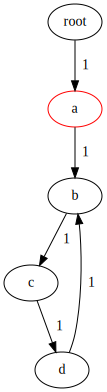

In [16]:
cbs = Callbacks()
cbs.append(Callback().withCheckpoint("a", lambda self: 0), "cb1")
cbs("a", "b", "c", "d", "b")
cbs.checkpointGraph("cb1")

In [11]:
#export
@k1lib.patch(Callbacks, "withs")
@property
def withs(self):
    """Gets all with- functions nicely formatted, with `order`
and `short docs` fields"""
    ws = [w for w in dir(Callbacks()) if w.startswith("with") and w != "withs"]
    ws.sort(); lname = 25; lorder = 6; ldocs = int(os.getenv('COLUMNS', 73)) - lname - lorder
    print("function name".ljust(lname) + "order".ljust(lorder) + "short docs")
    for w in ws:
        docs = ""; print(w.ljust(lname), end="")
        if w[4:] in Callback.cls:
            try:
                from inspect import signature
                cl = Callback.cls[w[4:]]; docs = docs or cl.__doc__
                params = [None] * (len(signature(cl.__init__).parameters) - 1)
                orderI = cl(*params).order; order = f"{orderI}".ljust(lorder)
                print((k1lib.format.grey if orderI == 10 else k1lib.format.identity)(order), end="")
            except Exception: print(" "*lorder, end="")
        else: print(" "*lorder, end="")
        print(k1lib.limitChars(docs or getattr(self, w).__doc__, ldocs))
    print(f"\nHere for order value suggestions: {k1lib._docsUrl}/callbacks")

In [12]:
k1lib.Callbacks().withs

function name            order short docs
withAccuracy             20     
withAdvanced                   Adds advanced Callbacks that do fancy stuf...
withAutosave             23    Autosaves 3 versions of the network to dis...
withBasics                     Adds a bunch of very basic Callbacks that'...
withBatchLimit           25    Cancels the epoch after executed certain n...
withBeep                 10    Plays a beep sound when the run is over
withCancelOnExplosion    25    Cancels the run if any of the parameters a...
withCancelOnHighAccuracy 25    Cancels the run if accuracy is higher than...
withCancelOnLowLoss      25     
withConfusionMatrix      10     
withCoreNormal           10    Just a normal, typical feed forward pass...
withCoreRNN              10    RNN forward pass
withCpu                  10    Moves batch and model to CPU
withCuda                 10    Moves batch and model to the default GPU...
withDType                10    Moves batch and model to a specified 

In [1]:
!../../export.py callbacks/callbacks

Current dir: /home/kelvin/repos/labs/k1lib, ../../export.py
rm: cannot remove '__pycache__': No such file or directory
Found existing installation: k1lib 0.1.11
Uninstalling k1lib-0.1.11:
  Successfully uninstalled k1lib-0.1.11
running install
running bdist_egg
running egg_info
creating k1lib.egg-info
writing k1lib.egg-info/PKG-INFO
writing dependency_links to k1lib.egg-info/dependency_links.txt
writing requirements to k1lib.egg-info/requires.txt
writing top-level names to k1lib.egg-info/top_level.txt
writing manifest file 'k1lib.egg-info/SOURCES.txt'
reading manifest file 'k1lib.egg-info/SOURCES.txt'
writing manifest file 'k1lib.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/k1lib
copying k1lib/_learner.py -> build/lib/k1lib
copying k1lib/data.py -> build/lib/k1lib
copying k1lib/selector.py -> build/lib/k1lib
copying k1lib/imports.py -> build/lib/k1lib
copying k1lib